**Datacube Exploration**

Rodrigo Brust Santos
_____

## Table of Contents

- [Importing Libraries](#importing-libraries)
- [Opening Files](#opening-files)
- [Creating NDVI](#creating-ndvi)
- [Inserting NDVI into the cube](#inserting-ndvi-into-the-cube)
- [NDVI Pixel Histograms](#ndvi-pixel-histograms)
- [Clipping the NDVI layer to the AOI](#clipping-the-ndvi-layer-to-the-aoi)
- [NDVI Average Timeseries within AOI](#ndvi-average-timeseries-within-aoi)
- [Creating RGB Plot](#creating-rgb-plot)
- [Interpretation](#interpretation)

## Importing Libraries <a id='#importing-libraries'></a>

In [1]:
# from functions import * # considered "bad" practice to import *, instead "import functions" so that people know where things are coming from.
import netCDF4 as nc
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import rioxarray as rxr
import warnings
warnings.filterwarnings('ignore')

In [2]:
import functions

## Opening Files <a id='opening-files'></a>

In [3]:
#set datacube path
cube_path = 'RawData/geospatial_test_datacube.nc'

#set geojson path
geojson = 'RawData/geospatial_sub_aoi.geojson'


#read datacube
dc  = xr.open_dataset(cube_path) 

#read geojson
aoi = gpd.read_file(geojson)

<Axes: >

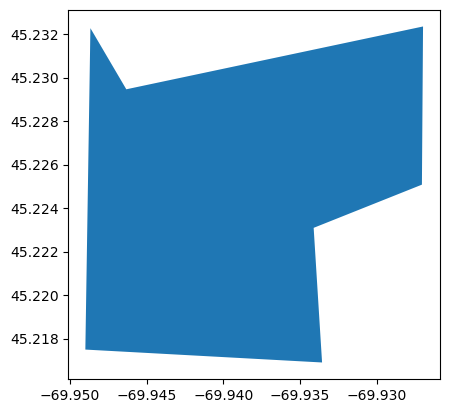

In [4]:
#confirming AOI shape
aoi.plot()

In [5]:
#checking AOI crs
aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
#getting AOI extreme coordinates to clip later.
bbox = np.array(aoi["geometry"][0].exterior.coords)
bbox

array([[-69.94866841,  45.23226754],
       [-69.9489978 ,  45.21749676],
       [-69.93355281,  45.21690378],
       [-69.93410181,  45.22309103],
       [-69.9270381 ,  45.22507596],
       [-69.9269649 ,  45.23234486],
       [-69.94632604,  45.22945804],
       [-69.94866841,  45.23226754]])

In [8]:
#summary of datacube
dc

<xarray.Dataset>
Dimensions:   (time: 23, y: 227, x: 304)
Coordinates:
  * time      (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y         (y) float32 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
  * x         (x) float32 -69.95 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED    (time, y, x) float32 ...
    S2_GREEN  (time, y, x) float32 ...
    S2_BLUE   (time, y, x) float32 ...
    S2_NIR    (time, y, x) float32 ...
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]

In [9]:
print('Time range is from:', dc['time'].values.min(),'to', dc['time'].values.max())

Time range is from: 2021-04-09T00:00:00.000000000 to 2021-11-25T00:00:00.000000000


## Creating NDVI <a id='creating-ndvi'></a>

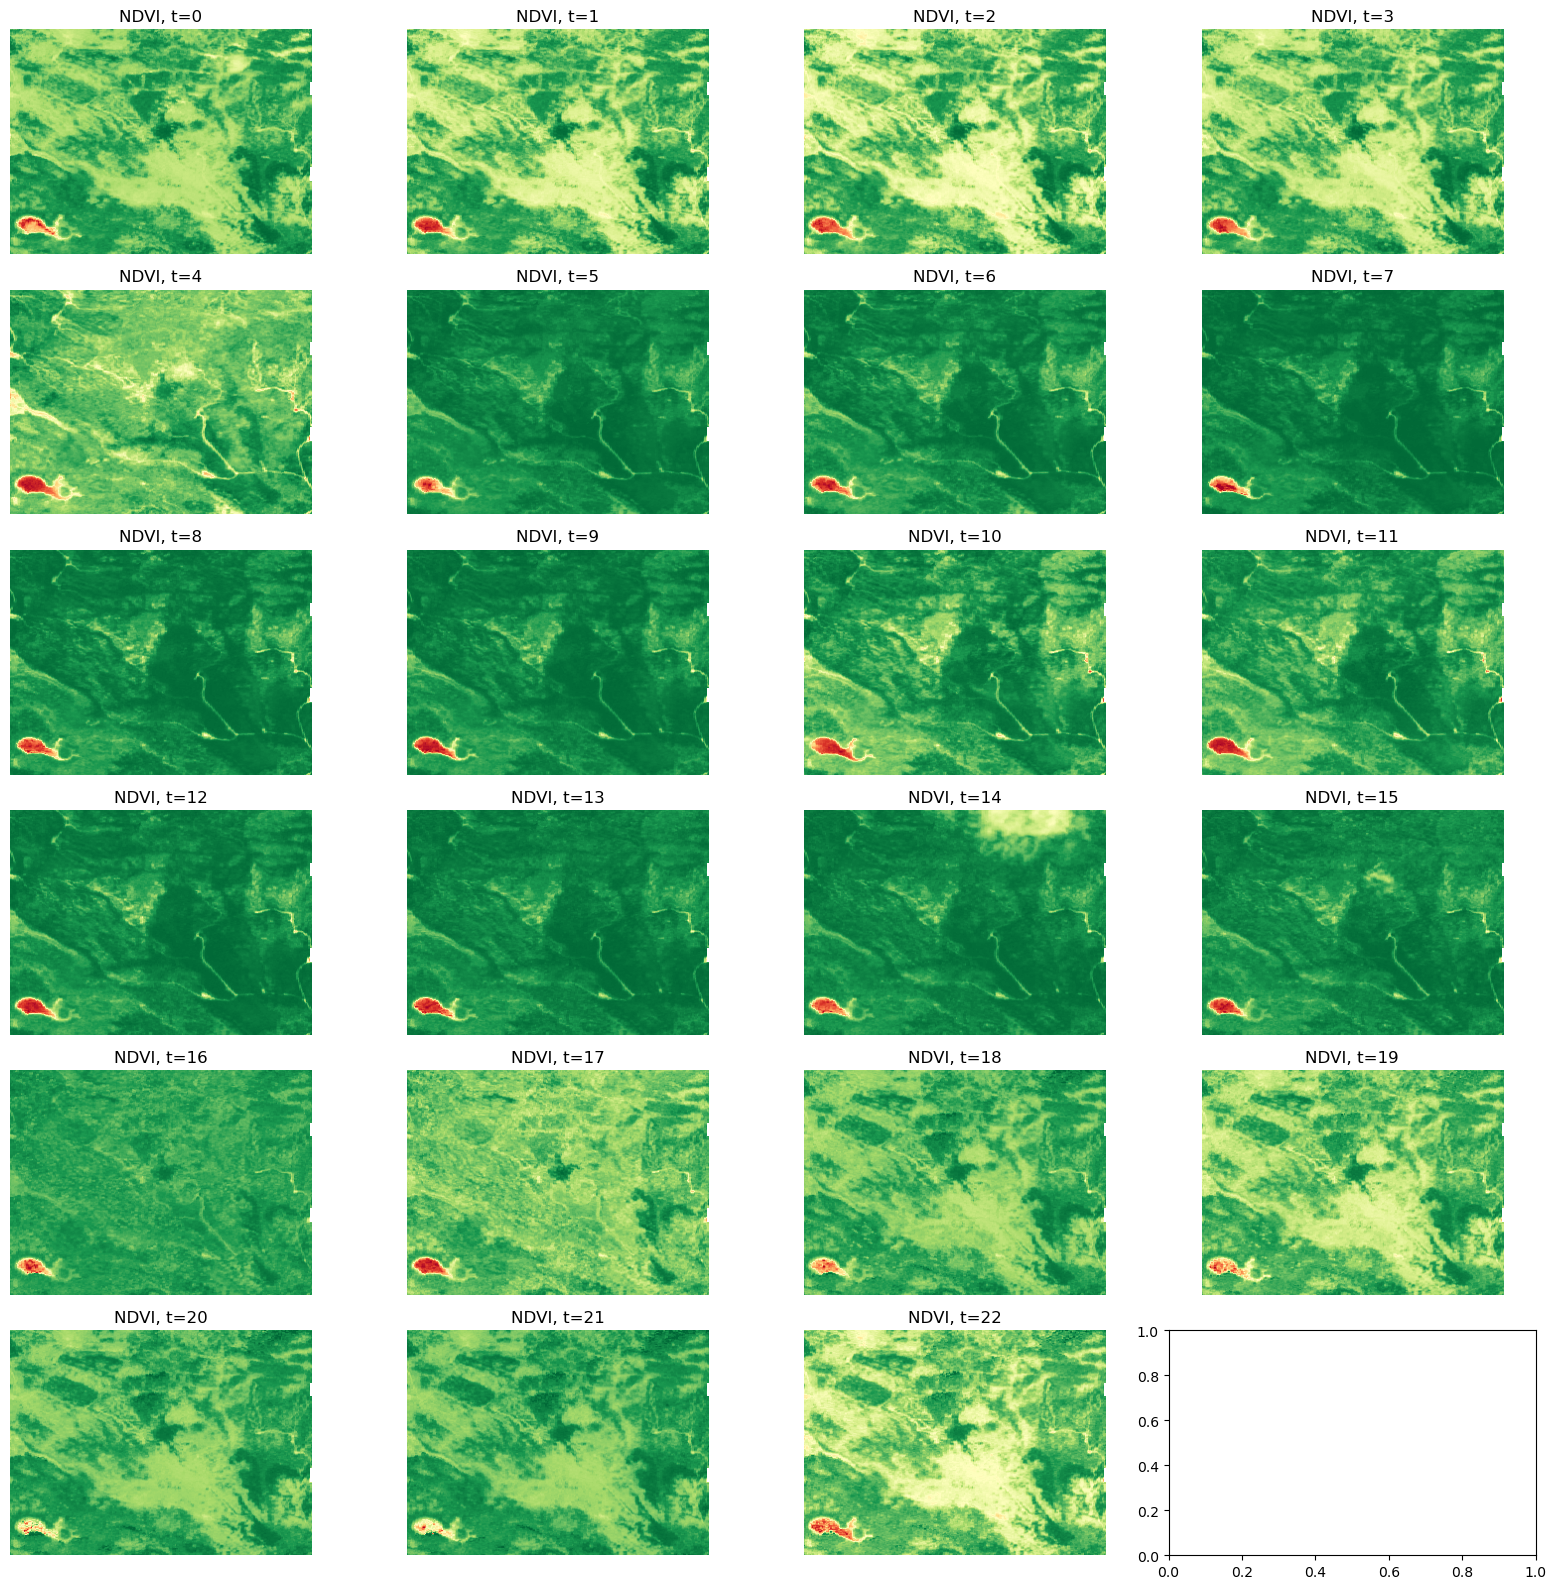

In [11]:
#selecting bands
nir = dc['S2_NIR'][:,:,:]
red = dc['S2_RED'][:,:,:]

#applying the function
ndvi = functions.ndvi_calc(red,nir) # This way other people know where the function is defined right away.


#creating a loop to plot all data according to the lenght of time range

time_range = len(dc['time'])

# Calculate NDVI for each time step
ndvi_all = []
for i in range(0,time_range):
    ndvi_v = ndvi[i,:,:] # (nir[i,:,:] - red[i,:,:]) / (nir[i,:,:] + red[i,:,:])
    ndvi_all.append(ndvi_v)


# Plot the NDVI values for each time step
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(16,16))
for i in range(0, time_range):
    row = i // 4
    col = i % 4
    ax[row,col].imshow(ndvi_all[i], cmap='RdYlGn')
    ax[row,col].set_title('NDVI, t=' + str(i))
    ax[row,col].set_axis_off()
    
plt.tight_layout()
plt.show()

## Inserting NDVI into the cube <a id='inserting-ndvi-into-the-cube'></a>

In [12]:
#inserting NDVI into the cube

# Create an xarray DataArray for NDVI with explicit dimensions
ndvi_dims = ('time', 'y', 'x')  # define the dimensions
dc['NDVI'] = xr.DataArray(ndvi, dims=ndvi_dims)  # create the DataArray


#Set CRS for the NDVI layer.
dc.NDVI.attrs['crs'] = 'epsg:4326'

dc

<xarray.Dataset>
Dimensions:   (time: 23, y: 227, x: 304)
Coordinates:
  * time      (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y         (y) float32 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
  * x         (x) float32 -69.95 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED    (time, y, x) float32 ...
    S2_GREEN  (time, y, x) float32 ...
    S2_BLUE   (time, y, x) float32 ...
    S2_NIR    (time, y, x) float32 ...
    NDVI      (time, y, x) float32 0.6231 0.6231 0.6612 ... 0.7311 0.8159 0.7271
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]

## NDVI Pixel Histograms <a id='ndvi-pixel-histograms'></a>

In [13]:
#transforming xarray to dataframe
ndvi_df = dc['NDVI'].to_dataframe()

#reseting index
ndvi_df = ndvi_df.reset_index()

#removing NaN values.
ndvi_df.dropna(inplace = True)

ndvi_df.head(10)

time          y          x      NDVI
0 2021-04-09  45.233162 -69.949860  0.623113
1 2021-04-09  45.233162 -69.949768  0.623113
2 2021-04-09  45.233162 -69.949677  0.661228
3 2021-04-09  45.233162 -69.949593  0.572001
4 2021-04-09  45.233162 -69.949501  0.572001
5 2021-04-09  45.233162 -69.949409  0.610475
6 2021-04-09  45.233162 -69.949318  0.562952
7 2021-04-09  45.233162 -69.949234  0.668385
8 2021-04-09  45.233162 -69.949142  0.668385
9 2021-04-09  45.233162 -69.949051  0.749380

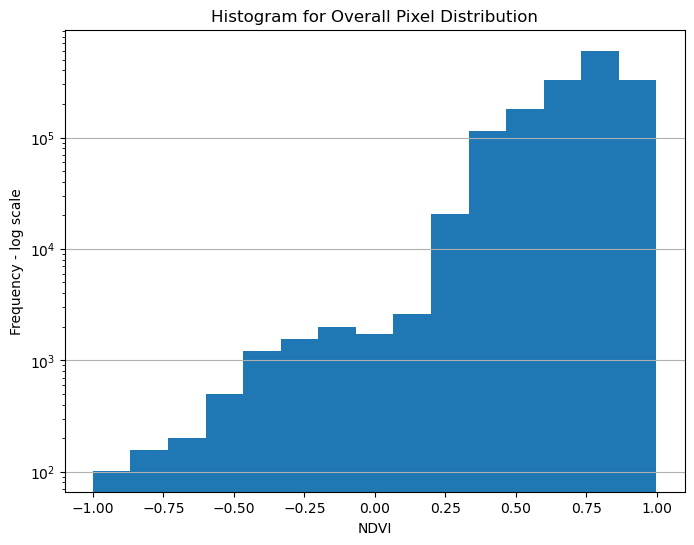

In [14]:
#Creating histogram visualization for 
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(ndvi_df['NDVI'],
        bins=15
       )

ax.set_title('Histogram for Overall Pixel Distribution')
ax.set_xlabel('NDVI')
ax.set_ylabel('Frequency - log scale')
ax.set_yscale('log')
plt.grid(axis = 'y')
plt.show()

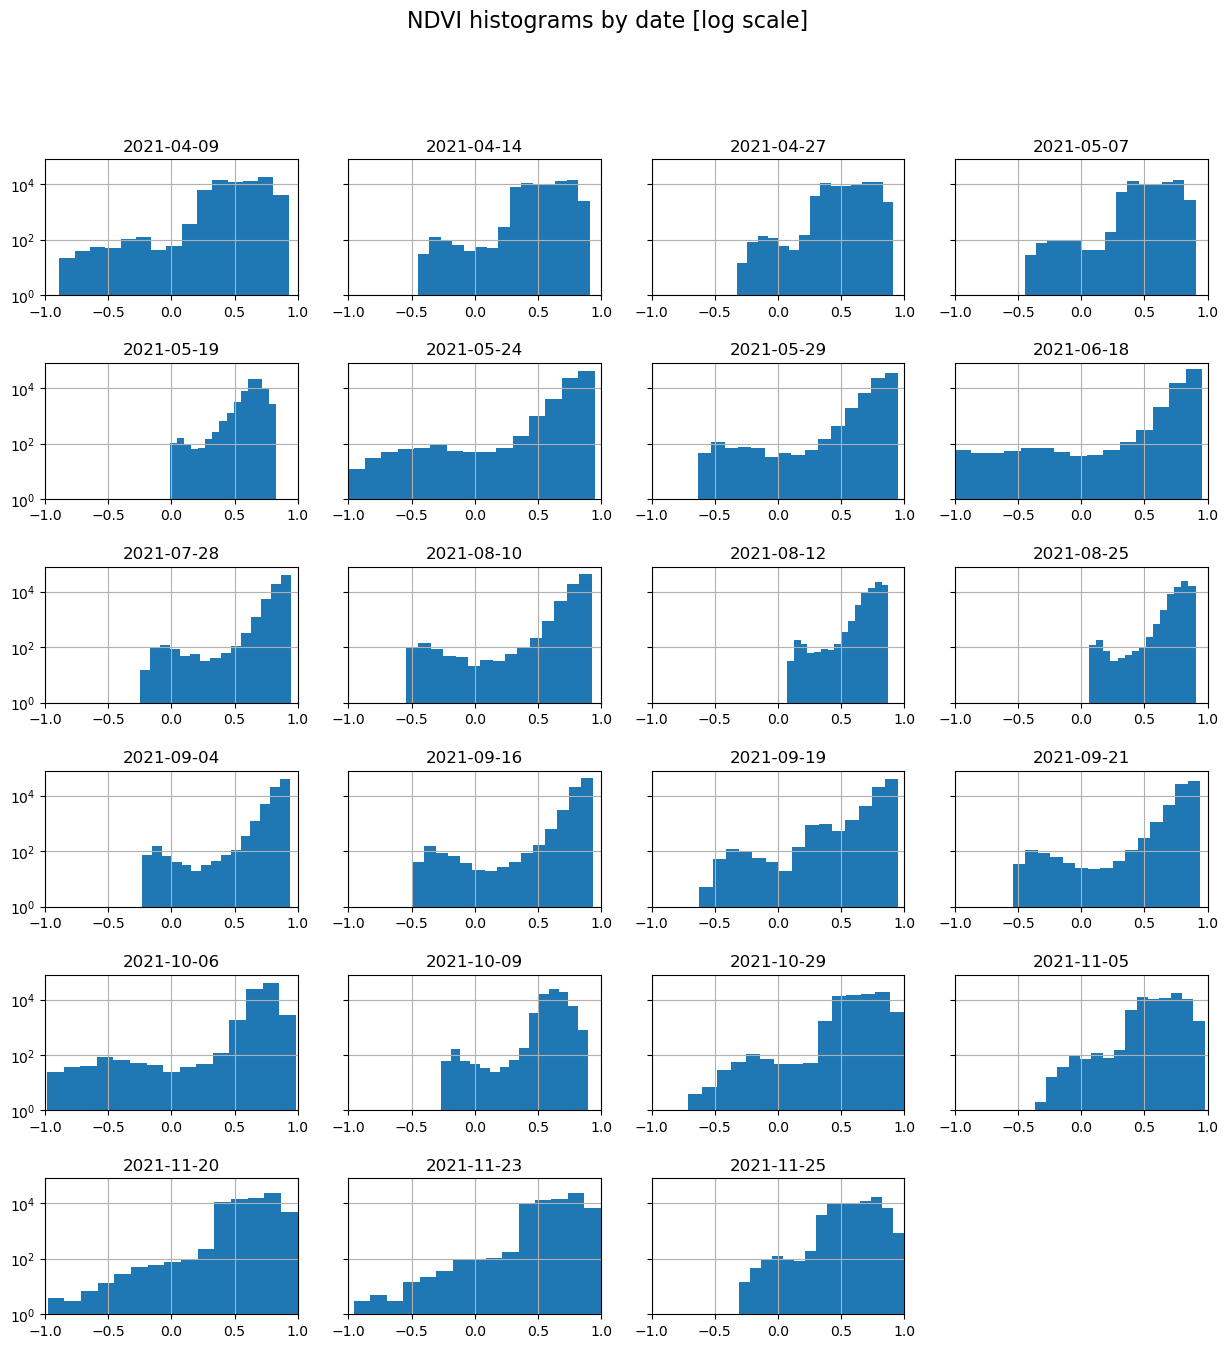

In [15]:
# Group the data by date
grouped = ndvi_df.groupby('time')


# Define the number of rows and columns in the chart grid
num_cols = 4
num_rows = (len(grouped) // num_cols) + (len(grouped) % num_cols > 0)

# Create a new figure and subplots
fig, axes = plt.subplots(num_rows,
                         num_cols,
                         figsize=(15, 15),
                         sharey=True,
                         gridspec_kw={
                                    'hspace': 0.5,
                                    'wspace': 0.2
                                    }
                        )

# Loop through the groups and plot the histograms in each subplot
for i, (date, group) in enumerate(grouped):
    row = i // num_cols
    col = i % num_cols
    group['NDVI'].hist(ax=axes[row][col], bins=15)
    axes[row][col].set_title(date.date())
    axes[row][col].set_xlim(-1, 1)
    axes[row][col].set_ylim(1, 80000)
    axes[row][col].set_yscale('log')
    
# Set the visibility of the empty subplot to False
for ax in axes.flat:
    if not ax.get_title():
        ax.set_visible(False)


# Add a global title to the chart
fig.suptitle('NDVI histograms by date [log scale]', fontsize=16)

# Show the chart
plt.show()

## Cliping the NDVI layer to the AOI <a id='cliping-the-ndvi-layer-to-the-aoi'></a>

In [16]:
#Filtering the coordinates from the bbox

bbox = np.array(list(aoi.geometry[0].exterior.coords))

#getting the espg code from the AOI
epsg = aoi.crs.to_epsg()

#creating a geometry variable with the bbox coords
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [bbox.tolist()]
    }
]


#clipping the datacube according to the geometry and keeping the same CRS
clipped = dc.rio.clip(geometries, crs = epsg )


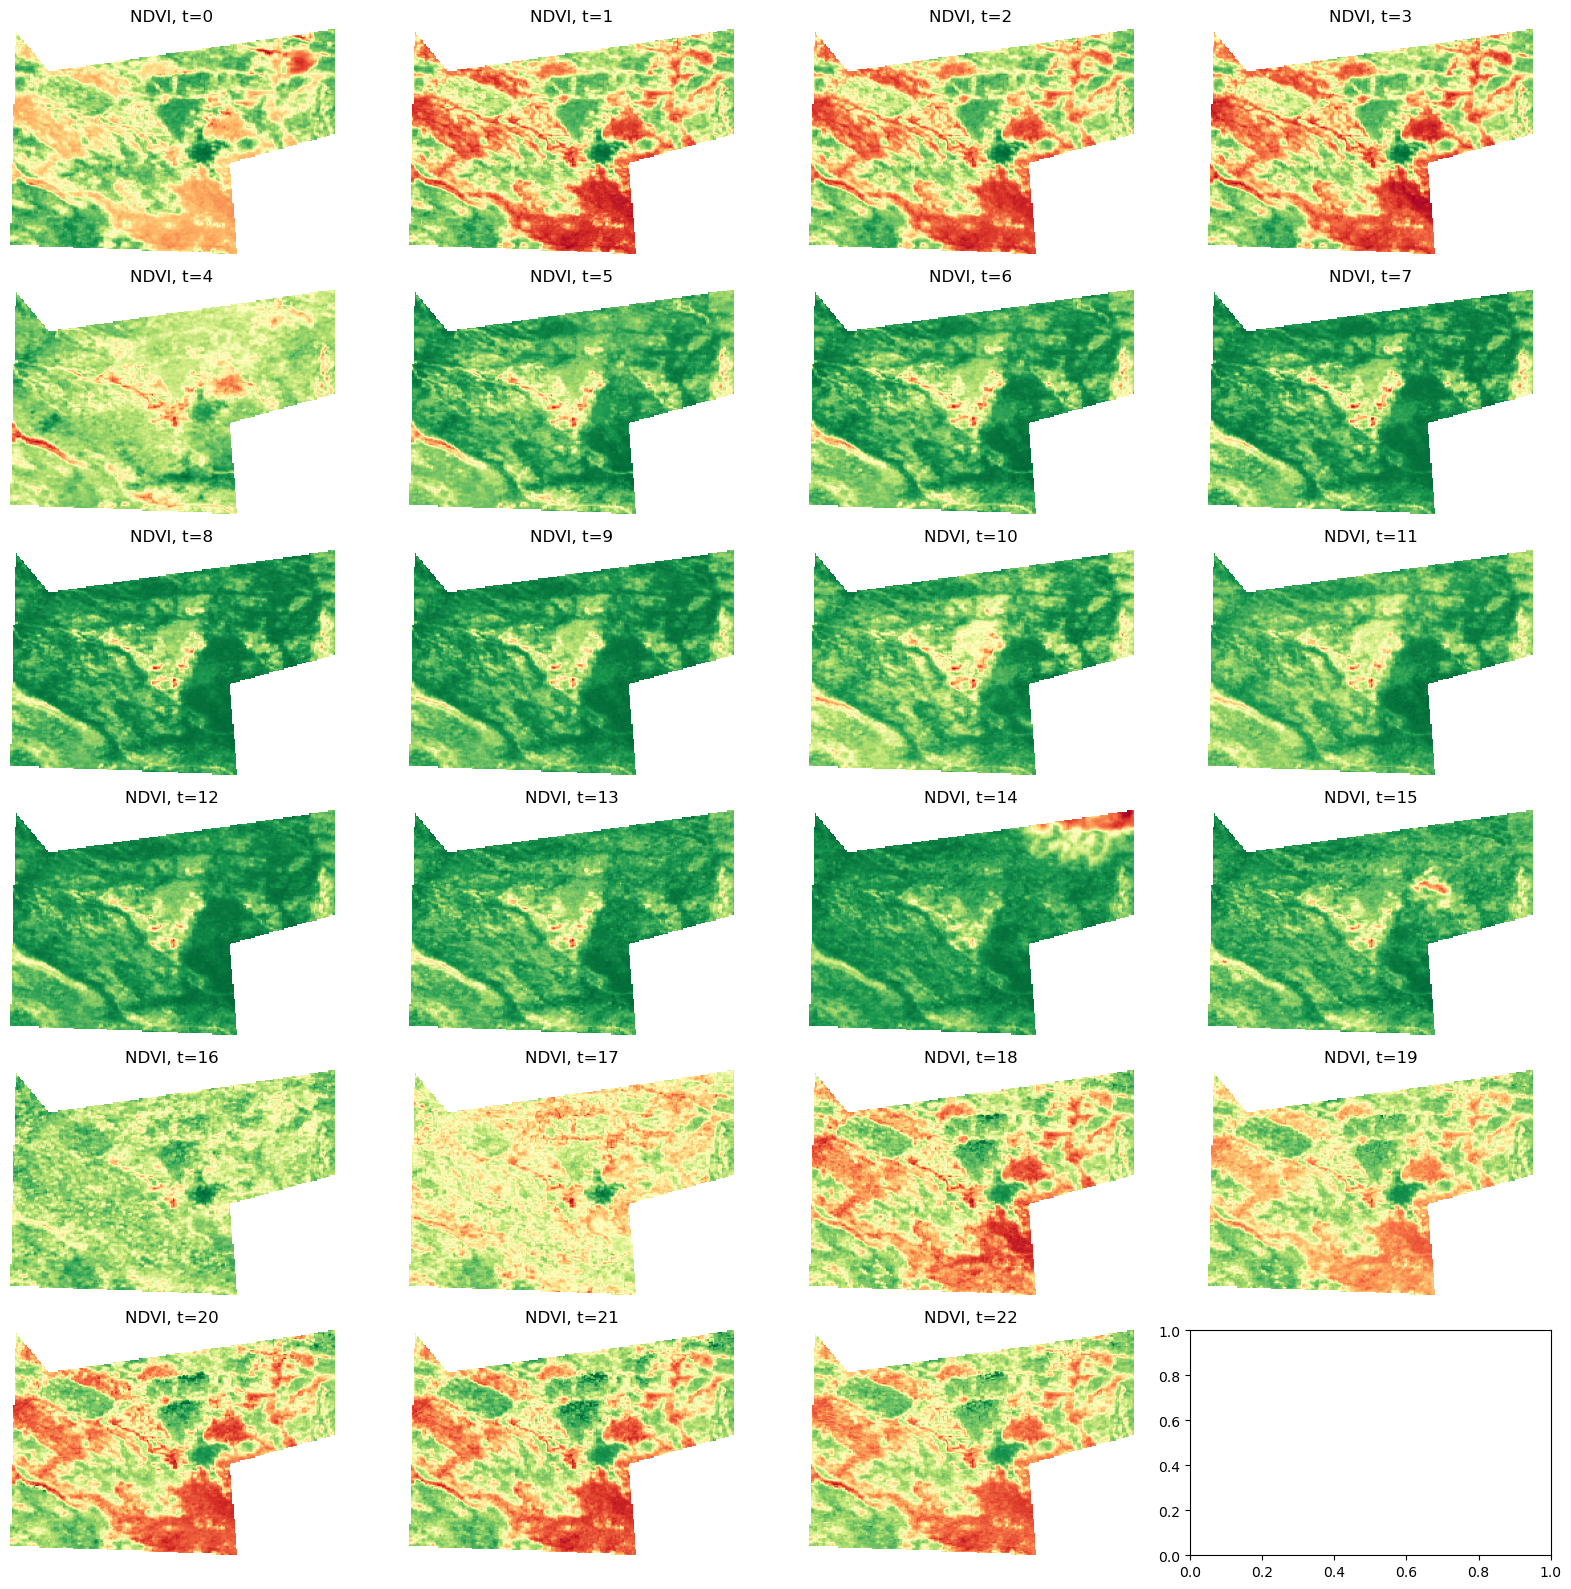

In [18]:
# Calculate NDVI for each time step

ndvi_all_c = []
for i in range(0,time_range):
    ndvi_c = functions.ndvi_calc(clipped['S2_RED'][i,:,:],
                       clipped['S2_NIR'][i,:,:]
                      ) 
    
    ndvi_all_c.append(ndvi_c)


# Plot the NDVI values for each time step
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(16,16))
for i in range(0, time_range):
    row = i // 4
    col = i % 4
    ax[row,col].imshow(ndvi_all_c[i], cmap='RdYlGn')
    ax[row,col].set_title('NDVI, t=' + str(i))
    ax[row,col].set_axis_off()
plt.tight_layout()
plt.show()

## NDVI Average Timeseries within AOI <a id='ndvi-average-timeseries-within-aoi'></a>

In [19]:
#creating df from clipped data
aoi_ndvi = clipped['NDVI'].to_dataframe()

# removing NaN values
aoi_ndvi.dropna(inplace = True)

#reseting index
aoi_ndvi = aoi_ndvi.reset_index()


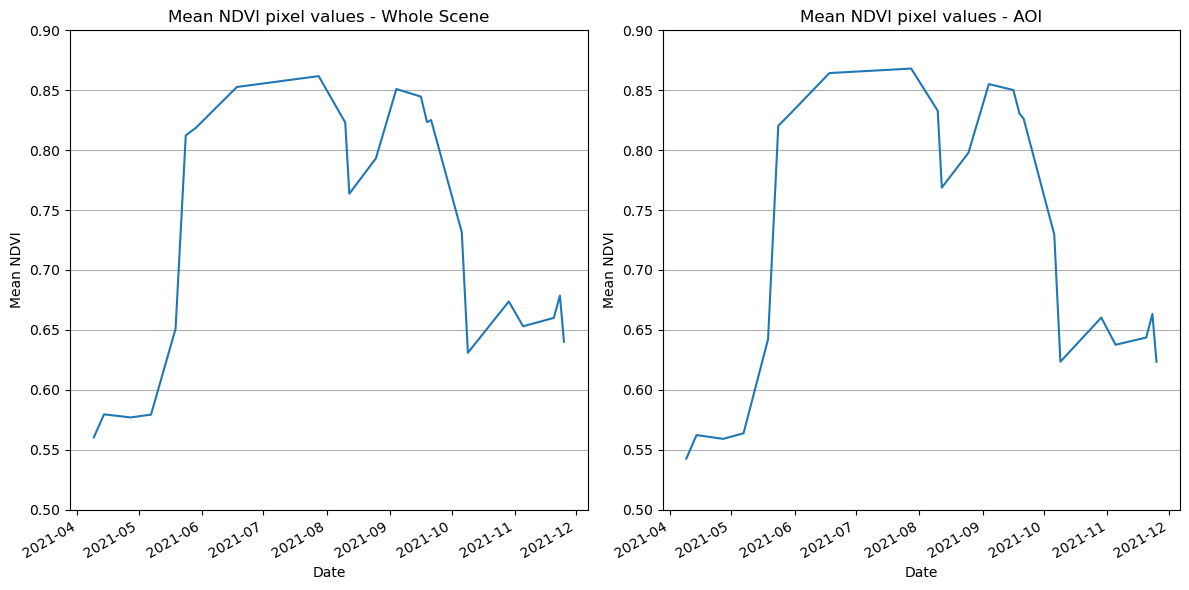

In [20]:
#Creating a plot to compare overall mean NDVI pixels and AOI
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

#whole scene plot
ndvi_df.groupby('time')['NDVI'].mean().plot(ax=axs[0], title='Mean NDVI pixel values - Whole Scene')

#AOI plot
aoi_ndvi.groupby('time')['NDVI'].mean().plot(ax=axs[1], title='Mean NDVI pixel values - AOI')

for ax in axs:
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean NDVI')
    ax.grid(axis = 'y')
    ax.set_ylim(0.50, 0.9)

plt.tight_layout()
plt.show()


## Creating RGB Plot <a id='creating-rgb-plot'></a>

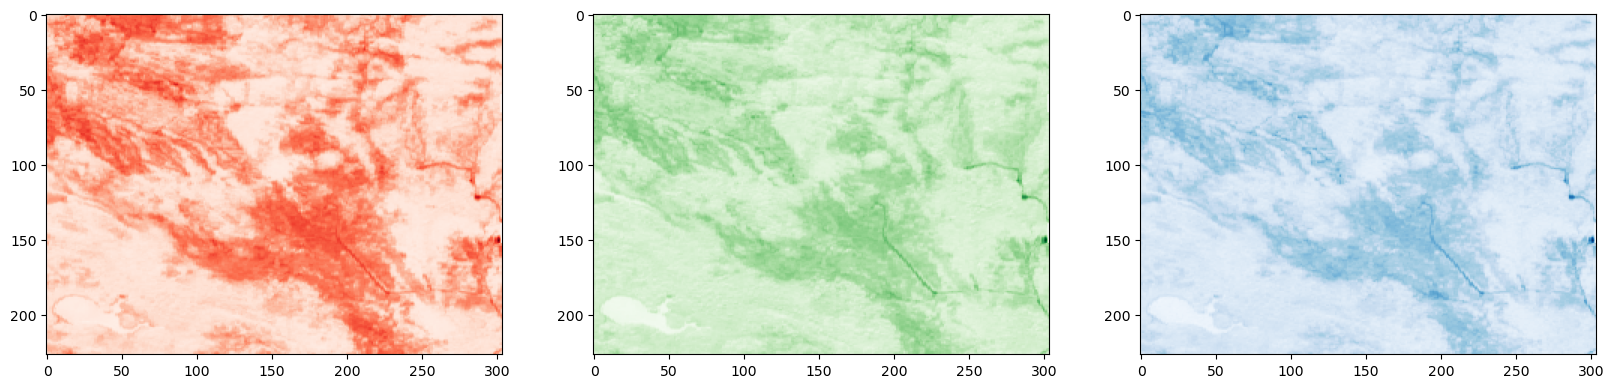

In [21]:
#plotting rgb

#selecting bands
red = dc['S2_RED'][1,:,:]
green = dc['S2_GREEN'][1,:,:]
blue = dc['S2_BLUE'][1,:,:]

#plotting 3 bands
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(red, cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(green, cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(blue, cmap='Blues');

(227, 304, 3)


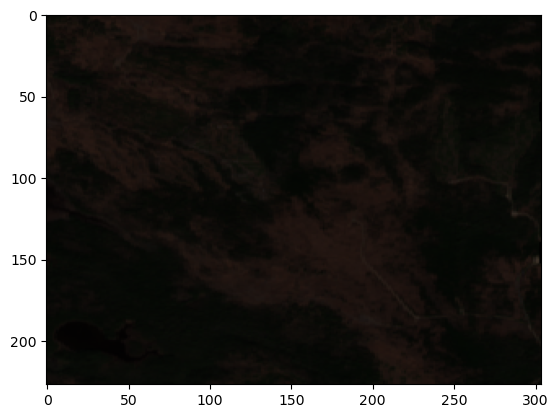

In [22]:
#making the composite and checking the dimensions
rgb_composite_raw= np.dstack((red, green, blue))
print(rgb_composite_raw.shape)

#visualizing
plt.imshow(rgb_composite_raw);

In [24]:
#normalizing

red_n = functions.normalize(red)
green_n = functions.normalize(green)
blue_n = functions.normalize(blue)

#checking normalization
print(red_n.max(), red.max())

<xarray.DataArray 'S2_RED' ()>
array(1., dtype=float32)
Coordinates:
    time     datetime64[ns] 2021-04-14 <xarray.DataArray 'S2_RED' ()>
array(0.238, dtype=float32)
Coordinates:
    time     datetime64[ns] 2021-04-14


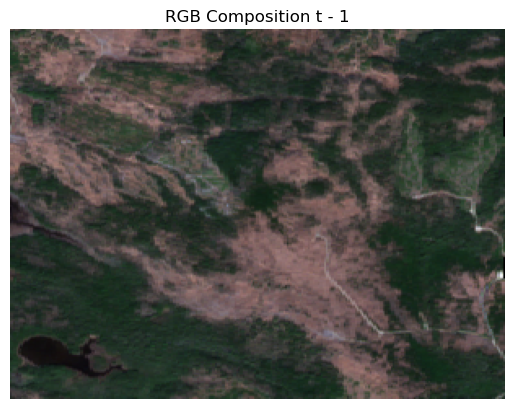

In [25]:
#stacking normalized bands
rgb_composite_n= np.dstack((red_n, green_n, blue_n))
plt.imshow(rgb_composite_n)
plt.title(f'RGB Composition t - 1')
plt.axis('off');

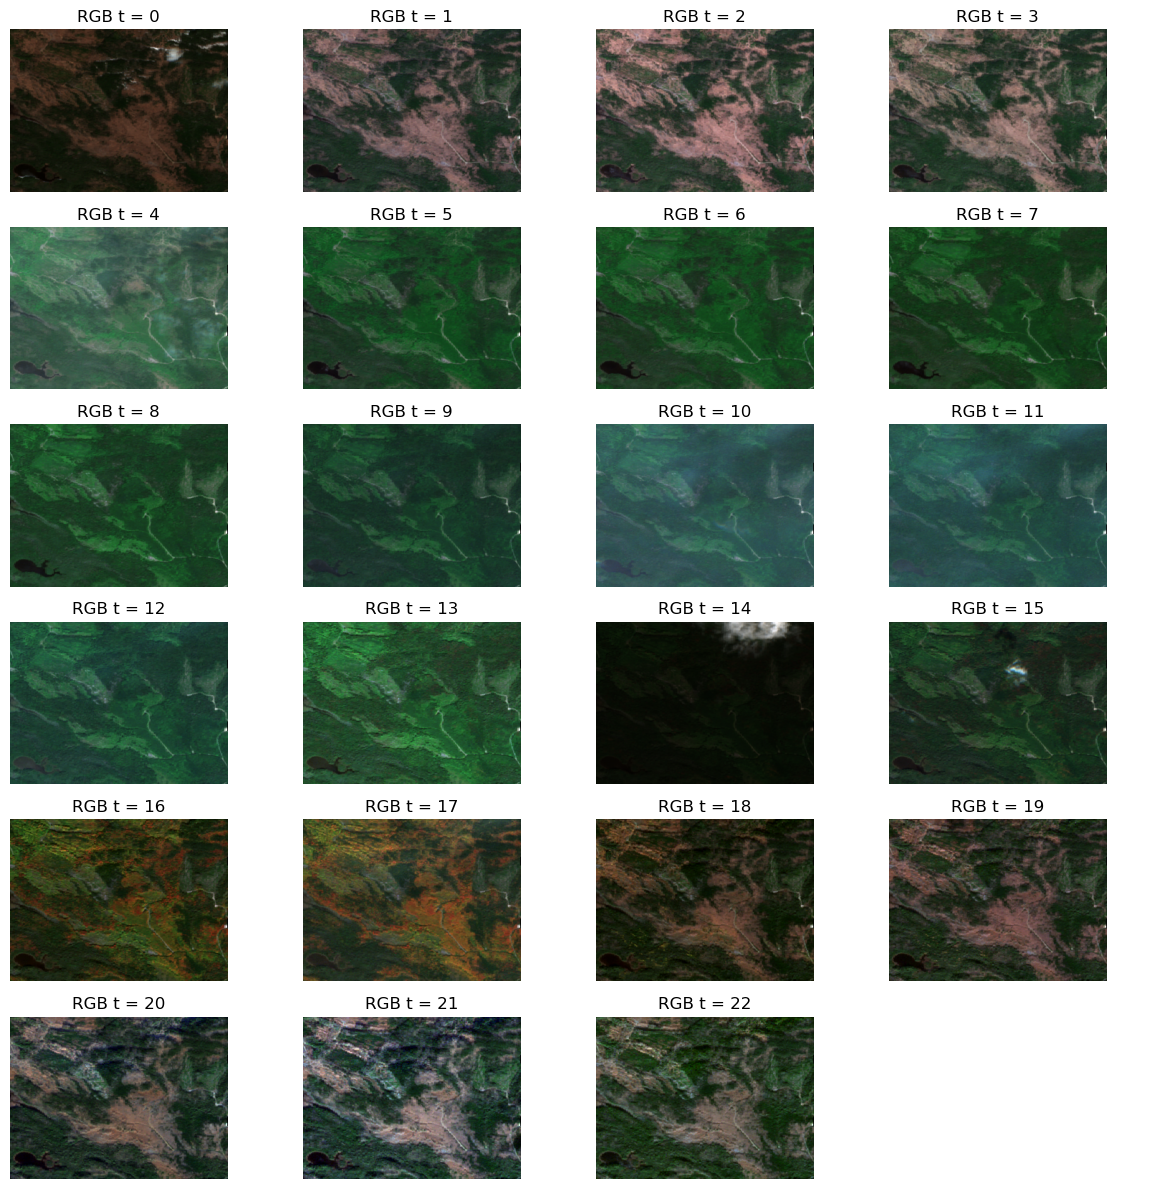

In [27]:

time_range = len(dc['time'])

fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    if i < time_range:
        #selecting bands
        r = dc['S2_RED'][i,:,:]
        g = dc['S2_GREEN'][i,:,:]
        b = dc['S2_BLUE'][i,:,:]

        #normalizing
        red_n = functions.normalize(r)
        green_n = functions.normalize(g)
        blue_n = functions.normalize(b)

        #applying the function
        rgb_composite_raw= np.dstack((red_n, green_n, blue_n))

        ax.set_title('RGB t = ' + str(i) )
        ax.imshow(rgb_composite_raw)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [28]:
#exporting the cube

dc.to_netcdf('Output/geospatial_test_datacube_processed.nc')
clipped.to_netcdf('Output/geospatial_test_datacube_processed_clipped.nc')

## Interpretation <a id='interpretation'></a>

The area of interest (AOI) is located near the city of Caratunk, Maine, USA. It is an area of forest and grassland, without any built areas.

The cube images cover dates from 2021-04-09 to 2021-11-25, indicating that it covers from spring to autumn - very relevant information when interpreting the results.

- **Overall NDVI**

The Normalized Difference Vegetation Index (NDVI) for the whole scene shows in the first 5 images (April 9th to May 19th) that the vegetation is not very healthy. Such affirmation is confirmed by the histograms, which have a high frequency of values below zero, and also by the pixel mean timeseries, which is between 0.55 and 0.65. This period is the transition between spring to summer.

The next 12 images (May 24th to October 6th) show that the vegetation is healthier, with more NDVI values above 0. Also, RGB images demonstrate how green the vegetation is, without any brown areas. Besides that, the mean pixel NDVI values have a peak at 0.86.

Finally, the last 6 images (October 9th to November 25th) show a small drop in the mean of NDVI pixels when compared to the last group - which also matches the end of summer and progression to autumn.

- **AOI NDVI**

Inside the AOI, the same pattern for the overall NDVI is also perceived, however with more detail.

The areas within the AOI that have the most changes in the NDVI index are the middle one and also the SE parts. This might not only be related to the condition of the vegetation but also to the presence of water, since the eastern part of the AOI has some stream heads.

Overall, the vegetation gets better during the summer, and in the months of April and May (spring) and October and November (autumn), it is less blooming.

This is also confirmed by the mean NDVI pixels for the AOI, which follows very closely the pattern of the whole scene chart, having very small variations in the values.

- **Conclusions**

    - During the summer, the vegetation presents its best shape in terms of healthiness.
    - Spring and autumn vegetation is not in its peak shape.
    - The eastern part of AOI not necessarily has more ill vegetation but might have more streams or even be a small bog.
    - The multiple resources for interpreting (histograms, timeseries, NDVI & RGB) point to the same direction as expected.
